# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# Point this to where you have downloaded the reacher app
env = UnityEnvironment(file_name='YOUR_REACHER_APP')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
from collections import deque
from tqdm import tqdm
import torch
import json
from datetime import datetime
from agent import *

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)


## To keep track of experiments
def append_to_file(text, filename):
    with open(filename, "a") as f:
        f.write(text + "\n")
        
def write_json(dd, filename):
    with open(filename, "w") as f:
        json.dump(dd, f, indent=4)
        
def ddpg(n_episodes=300, max_t=10000, learn_every=20, learn_steps=10, print_every=20, solved_rewards_threshold=30):
    
    start_time = str(datetime.now())
    best_score = -1

    hypes = {
        "BUFFER_SIZE":BUFFER_SIZE,
        "BATCH_SIZE":BATCH_SIZE,
        "GAMMA":GAMMA,
        "TAU":TAU,
        "LR_ACTOR": LR_ACTOR,
        "LR_CRITIC": LR_CRITIC,
        "WEIGHT_DECAY":WEIGHT_DECAY,
        "ACTOR": str(agent.actor_local).split("\n"),
        "CRITIC": str(agent.critic_local).split("\n")
    }

    write_json(hypes, start_time + " HYPES.json")
        
    # The goal is to get an average of > 30 on the last 100 scores
    # However, due to the volatile nature of DDPGs and how rapidly the agent 
    # can be updated, let's average over the last 5 scores to see if 
    # the agent can solve the environment
    local_scores_deque = deque(maxlen=5)

    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []
    for i_episode in tqdm(range(1, n_episodes+1)):
        # Reset env and agent
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            # Get the SARS tuple
            states = env_info.vector_observations
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            # Don't think "done" really applies to this task because it's not episodic
            # But just in case
            dones = env_info.local_done
            if np.any(dones):
                break
                
            # Add it to the agent. This will add to replay buffer + learn
            # This just builds up TONS of experience pretty quickly
            for s,a,r,n,d in zip(states, actions, rewards, next_states, dones):
                agent.add_experiences(s,a,r,n,d)
            
            # Since the experience is being built up pretty fast
            # 20 x 20 = 400 new experiences before learning some stuff
            if t % learn_every == 0:
                for _ in range(learn_steps):
                    agent.learn()
            
            # This helps keep track of the current episode's reward
            score += env_info.rewards

        avg_score = np.mean(score)
        local_scores_deque.append(avg_score)
        scores_deque.append(avg_score)
        scores.append(avg_score)
        
        score_mean_tuple = (scores[-1], np.mean(scores_deque))
        append_to_file(str(score_mean_tuple), start_time + " RUN.txt")        
        
        avg_scores.append(np.mean(scores_deque))
        
        
        if np.mean(scores_deque) > solved_rewards_threshold:
            print("The environment has been solved. Saving checkpoints")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')
            break
        elif np.mean(local_scores_deque) > solved_rewards_threshold+1:
            # Giving a little bit of wiggle room for error. Shouldn't need that much wiggle room
            # because it's already average scores over 20 agents
            tqdm.write("Local scores has surpassed threshold. Has the environment been solved?")
            check_scores = check_env_solved(env, agent)
            if np.mean(check_scores) > solved_rewards_threshold:
                tqdm.write("Environment has been solved!")
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')
                scores = check_scores
                break
            else:
                tqdm.write("Environment has not been solved. Continuing training...")
                
        if i_episode % print_every == 0:                
            tqdm.write('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            if avg_scores[-1] > best_score:
                tqdm.write("Best score has exceeded last average score {:.2f} vs {:.2f}".format(best_score, avg_scores[-1]))
                best_score = avg_scores[-1]
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    return scores

def check_env_solved(env, agent, num_episodes = 100, scores_thresholds = 30):

    env_info = env.reset(train_mode=True)[brain_name]
    agent.reset()
    scores_deque = deque(maxlen=100)
    
    for _ in range(num_episodes):
        score = np.zeros(num_agents)
        while True:
            # Keep acting until the env is done
            states = env_info.vector_observations
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            score += env_info.rewards
            dones = env_info.local_done
            if np.any(dones):
                break

        scores_deque.append(np.mean(score))
        
    return scores_deque
    

In [5]:
final_scores = ddpg(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/adlam/udacity/p2_proj/solved/agent.py:113: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
  2%|▏         | 20/1000 [03:20<2:53:03, 10.60s/it]

Episode 20	Average Score: 0.34
Best score has exceeded last average score -1.00 vs 0.34


  4%|▍         | 40/1000 [07:28<3:22:37, 12.66s/it]

Episode 40	Average Score: 0.65
Best score has exceeded last average score 0.34 vs 0.65


  6%|▌         | 60/1000 [12:04<3:39:24, 14.00s/it]

Episode 60	Average Score: 1.34
Best score has exceeded last average score 0.65 vs 1.34


  8%|▊         | 80/1000 [16:43<3:34:31, 13.99s/it]

Episode 80	Average Score: 2.31
Best score has exceeded last average score 1.34 vs 2.31


 10%|█         | 100/1000 [21:23<3:30:17, 14.02s/it]

Episode 100	Average Score: 3.12
Best score has exceeded last average score 2.31 vs 3.12


 12%|█▏        | 120/1000 [26:05<3:25:06, 13.98s/it]

Episode 120	Average Score: 4.87
Best score has exceeded last average score 3.12 vs 4.87


 14%|█▍        | 140/1000 [30:46<3:25:02, 14.31s/it]

Episode 140	Average Score: 6.93
Best score has exceeded last average score 4.87 vs 6.93


 16%|█▌        | 160/1000 [35:28<3:17:58, 14.14s/it]

Episode 160	Average Score: 9.13
Best score has exceeded last average score 6.93 vs 9.13


 18%|█▊        | 180/1000 [40:11<3:12:27, 14.08s/it]

Episode 180	Average Score: 11.36
Best score has exceeded last average score 9.13 vs 11.36


 20%|██        | 200/1000 [44:55<3:08:01, 14.10s/it]

Episode 200	Average Score: 14.45
Best score has exceeded last average score 11.36 vs 14.45


 22%|██▏       | 220/1000 [49:37<3:04:18, 14.18s/it]

Episode 220	Average Score: 17.61
Best score has exceeded last average score 14.45 vs 17.61


 23%|██▎       | 228/1000 [51:45<3:02:39, 14.20s/it]

Local scores has surpassed threshold. Has the environment been solved?


 23%|██▎       | 228/1000 [58:11<3:02:39, 14.20s/it]

Environment has been solved!


When finished, you can close the environment.

## Watch your agent!

In [74]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='../Reacher 2.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Watch your agent

In [85]:
from agent import Agent
from collections import deque
from tqdm import tqdm
import torch
import json
from datetime import datetime
import time

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor_final.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_final.pth'))
agent.reset()


for _ in range(1):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    agent.reset()

    score = np.zeros(num_agents)
    while True:
        # Keep acting until the env is done
        states = env_info.vector_observations
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        score += env_info.rewards
        dones = env_info.local_done
        if np.any(dones):
            break
    
    print(score)
    print(np.mean(score))


[39.16999912 39.14999912 39.52999912 27.82999938 35.27999921 39.43999912
 37.11999917 39.20999912 38.31999914 36.51999918 39.27999912 37.37999916
 25.39999943 36.92999917 38.18999915 33.37999925 39.56999912 33.19999926
 37.90999915 36.60999918]
36.47099918480963


### Plot some rewards 

In [101]:
def make_reward_graph(filename):
    scores = []
    with open(filename, "r") as fh:
        line = fh.readline()
        while line:
            curr_reward = float(line[1:-1].split(",")[0])
            scores.append(curr_reward)
            line = fh.readline()

    last_100_avg = []
    last_5_avg = []
    for win in window(scores, 5):
        last_5_avg.append(np.mean(win))

    for win in window(scores, 100):
        last_100_avg.append(np.mean(win))    

    plt.figure(figsize=(15,7.5))           
    plt.plot(scores)
    plt.plot(range(5, len(last_5_avg)+5), last_5_avg)
    plt.plot(range(100, len(last_100_avg)+100), last_100_avg)
    plt.xlabel("Number of Episodes")
    plt.ylabel("Rewards")
    plt.title("Rewards over Time")
    plt.legend(["Current Score", "Last 5 Avg Score", "Last 100 Avg Score"])
    plt.grid()     

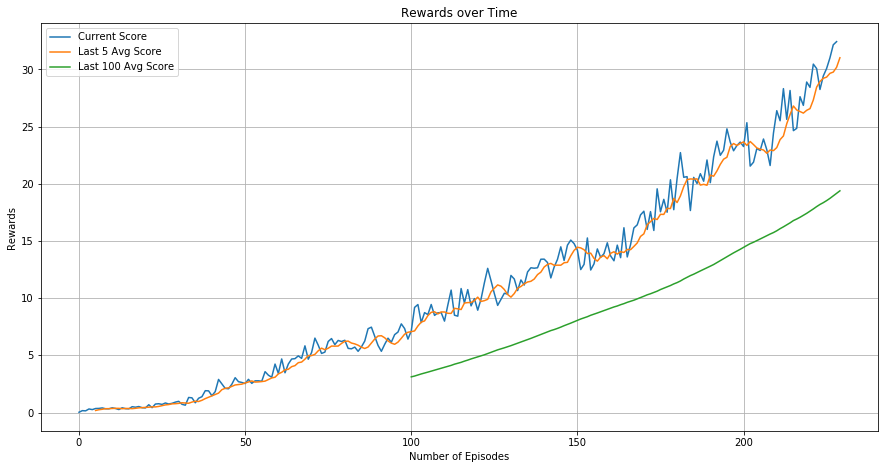

In [104]:
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result


# Unstable success: ./scores/2018-12-08 20_53_32.250268 RUN.txt
# Success: ./scores/2018-12-09 19:08:37.149953 RUN.txt
# Failure: ./scores/2018-12-09 13:02:45.408948 RUN.txt
# Failure but barely a success: ./scores/2018-12-08 18:00:36.618063 RUN.txt
# Failure but technically a success: ./scores/2018-12-08 20:26:12.994283 RUN.txt
make_reward_graph("./scores/2018-12-09 19:08:37.149953 RUN.txt")
plt.savefig('success.png')